In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from scipy.stats import kurtosis
from collections import Counter
import time
import warnings
import datetime
import matplotlib.pylab as plt
import math
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
import pandarallel as pdl
pdl.pandarallel.initialize(10000)

New pandarallel memory created - Size: 10000 MB
Pandarallel will run on 88 workers


In [3]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

In [4]:
train_df = pd.read_csv('dataset/train.csv', parse_dates=['auditing_date', 'due_date', 'repay_date'])

In [5]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.7045
2,404196,2355665,2018-02-18,2018-03-18,307.9270,\N,\N
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.9809
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.6503


In [6]:
def plus_1_day(s):
    return s + datetime.timedelta(days=1)

In [7]:
# 如果违约,还款日期为due_date的后一天
train_df['repay_date'] = train_df[['due_date', 'repay_date']].apply(
    lambda x: x['repay_date'] if x['repay_date'] != '\\N' else plus_1_day(x['due_date']), axis=1
)

In [8]:
# 如果违约,还款金额为0
train_df['repay_amt'] = train_df['repay_amt'].apply(lambda x: x if x != '\\N' else 0).astype('float32')

In [9]:
# 设定label
train_df['label'] = (train_df['due_date'] - train_df['repay_date']).dt.days

In [10]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt,label
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.116699,0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.704498,1
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2018-03-19,0.000000,-1
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.980896,0
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.650299,6


In [11]:
train_df['label'].value_counts(sort=False)

 0     408187
 1     121085
 2      59430
 3      56404
 4      26425
 5      21380
 6      17568
 7      14797
 8      12993
 9      11393
 10      9984
 11      9002
 12      8219
 13      7688
 14      6920
 15      6443
 16      6231
 17      5832
 18      5492
 19      5108
 20      4788
 21      4504
 22      4295
 23      4197
 24      3922
 25      3934
 26      3930
 27      4102
 28      4677
 29      5645
 30      9865
 31      8368
-1     117192
Name: label, dtype: int64

In [12]:
train_df['label'].nunique()

33

In [13]:
# 为什么要把-1换作32:方便分类编号和日期对应
# train_df.loc[train_df['repay_amt'] == -1, 'label'] = 32 错误写法
train_df['label'].replace(-1, 32, inplace=True)

In [14]:
clf_labels = train_df['label'].values

In [15]:
clf_labels.shape

(1000000,)

In [16]:
amt_labels = train_df['repay_amt'].values

In [17]:
train_due_amt_df = train_df['due_amt'].values

In [18]:
train_num = train_df.shape[0]

In [19]:
test_df = pd.read_csv('dataset/test.csv', parse_dates=['auditing_date', 'due_date'])

In [20]:
test_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt
0,498765,5431438,2019-03-12,2019-04-12,138.5903
1,34524,5443211,2019-03-15,2019-04-15,208.0805
2,821741,5461707,2019-03-22,2019-04-22,421.2097
3,263534,5472320,2019-03-26,2019-04-26,212.6537
4,238853,5459750,2019-03-21,2019-04-21,817.4593


In [21]:
sub = test_df[['user_id', 'listing_id', 'auditing_date', 'due_amt', 'due_date']]

In [22]:
sub.head()

,user_id,listing_id,auditing_date,due_amt,due_date
0,498765,5431438,2019-03-12,138.5903,2019-04-12
1,34524,5443211,2019-03-15,208.0805,2019-04-15
2,821741,5461707,2019-03-22,421.2097,2019-04-22
3,263534,5472320,2019-03-26,212.6537,2019-04-26
4,238853,5459750,2019-03-21,817.4593,2019-04-21


In [23]:
test_df.shape

(130000, 5)

In [24]:
df = pd.concat([train_df.drop(columns=['label','repay_amt','repay_date']), test_df], axis=0, ignore_index=True)

In [25]:
df.shape

(1130000, 5)

In [26]:
df_listing_id = df['listing_id']

In [27]:
# 时间对比控制不用未来的数据
def merge_before_auditing(df, df2, df2_time='info_insert_date', on='user_id'):
    df3 = df.merge(df2, on=on, how='left')
    df4 = df3[(df3['auditing_date']>df3[df2_time])]
    df5 = df.merge(df4, on=df.columns.tolist(), how='left')
    return df5

# *listing_info*

In [28]:
listing_info_df = pd.read_csv('dataset/listing_info.csv', parse_dates=['auditing_date'])

In [29]:
listing_info_df['principal_per_term'] = listing_info_df['principal'] / listing_info_df['term']

In [30]:
listing_info_df.head()

,user_id,listing_id,auditing_date,term,rate,principal,principal_per_term
0,316610,1556649,2017-11-26,9,7.6,4800,533.333333
1,62002,1556633,2017-11-26,6,7.6,4000,666.666667
2,192135,1556629,2017-11-26,12,8.0,8660,721.666667
3,487382,1556628,2017-11-26,9,7.6,4780,531.111111
4,235186,1556627,2017-11-26,9,7.6,1480,164.444444


## 历史贷款信息的统计特征

In [31]:
listing_hist_df = listing_info_df.drop(columns=['listing_id'])
listing_hist_df.rename({'auditing_date': 'hist_auditing_date'},axis=1,inplace=True)

In [32]:
df = merge_before_auditing(df, listing_hist_df, df2_time='hist_auditing_date', on="user_id")

In [33]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_auditing_date,term,rate,principal,principal_per_term
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-04-22,12.0,8.6,1170.0,97.500000
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-11-10,6.0,8.0,5540.0,923.333333
2,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-04-12,9.0,7.2,1170.0,130.000000
3,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-09-29,3.0,8.0,1710.0,570.000000
4,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-06-05,6.0,8.6,2260.0,376.666667


In [34]:
# 总估算利息
df['interest']=(1+df['term'])*df['principal']*df['rate']/24

In [35]:
groups = df.groupby('listing_id', as_index=False)

In [36]:
# 历史借款数
df = df.merge(groups['principal'].agg({'hist_loans': len}))

In [37]:
# 'pricipal'为空时历史借款数为0
df.loc[df['principal'].isnull(),'hist_loans']=0

In [38]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_auditing_date,term,rate,principal,principal_per_term,interest,hist_loans
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-04-22,12.0,8.6,1170.0,97.500000,5450.250000,1.0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-11-10,6.0,8.0,5540.0,923.333333,12926.666667,9.0
2,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-04-12,9.0,7.2,1170.0,130.000000,3510.000000,9.0
3,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-09-29,3.0,8.0,1710.0,570.000000,2280.000000,9.0
4,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-06-05,6.0,8.6,2260.0,376.666667,5668.833333,9.0


In [39]:
# 历史总估算利息统计
df = df.merge(groups['interest'].agg({
    'hist_interest_mean':'mean', 'hist_interest_median':'median', 'hist_interest_std':'std', 'hist_interest_max':'max', 
    'hist_interest_min':'min', 'hist_interest_skew':'skew', 'hist_interest_sum':'sum'
}), on = 'listing_id', how='left')

In [40]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_auditing_date,term,rate,principal,principal_per_term,interest,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-04-22,12.0,8.6,1170.0,97.500000,5450.250000,1.0,5450.250000,5450.25,NaN,5450.250000,5450.25,NaN,5450.25
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-11-10,6.0,8.0,5540.0,923.333333,12926.666667,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50
2,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-04-12,9.0,7.2,1170.0,130.000000,3510.000000,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50
3,672952,3698760,2018-06-09,2018-07-09,258.7045,2017-09-29,3.0,8.0,1710.0,570.000000,2280.000000,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50
4,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-06-05,6.0,8.6,2260.0,376.666667,5668.833333,9.0,5386.166667,3510.00,3251.016384,12926.666667,2280.00,1.767087,48475.50


In [41]:
# 历史借款额统计
df = df.merge(groups['principal'].agg({
    'hist_principal_mean':'mean', 'hist_principal_median':'median', 'hist_principal_std':'std', 'hist_principal_max':'max', 
    'hist_principal_min':'min', 'hist_principal_skew':'skew', 'hist_principal_sum':'sum'
}), on = 'listing_id', how='left')

In [42]:
# 历史期数统计
df = df.merge(groups['term'].agg({
    'hist_term_mean':'mean', 'hist_term_median':'median', 'hist_term_std':'std', 'hist_term_max':'max', 
    'hist_term_min':'min', 'hist_term_skew':'skew', 'hist_term_sum':'sum'
}), on = 'listing_id', how='left')

In [43]:
# 历史期均借款额统计
df = df.merge(groups['principal_per_term'].agg({
    'principal_per_term_mean':'mean', 'principal_per_term_median':'median', 'principal_per_term_std':'std', 
    'principal_per_term_max':'max', 'principal_per_term_min':'min', 'principal_per_term_skew':'skew', 
    'principal_per_term_sum':'sum'
}), on = 'listing_id', how='left')

In [44]:
# 留下最新的'hist_auditing_date’数据，计算距离最近一次贷款的天数
df = df.sort_values(by='hist_auditing_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [45]:
# df['days_after_last_loan'] = (df['auditing_date']-df['hist_auditing_date']).dt.days

In [46]:
del df['hist_auditing_date'], df['term'], df['rate'], df['principal'], df['interest'], df['principal_per_term']

## 当前贷款信息的特征

In [47]:
del listing_info_df['user_id'], listing_info_df['auditing_date']

In [48]:
listing_info_df.head()

,listing_id,term,rate,principal,principal_per_term
0,1556649,9,7.6,4800,533.333333
1,1556633,6,7.6,4000,666.666667
2,1556629,12,8.0,8660,721.666667
3,1556628,9,7.6,4780,531.111111
4,1556627,9,7.6,1480,164.444444


In [49]:
listing_info_df.head()

,listing_id,term,rate,principal,principal_per_term
0,1556649,9,7.6,4800,533.333333
1,1556633,6,7.6,4000,666.666667
2,1556629,12,8.0,8660,721.666667
3,1556628,9,7.6,4780,531.111111
4,1556627,9,7.6,1480,164.444444


In [50]:
df = df.merge(listing_info_df, on='listing_id', how='left')

In [51]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term
0,748147,3163926,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,198.194444,198.194444,142.403449,298.888889,97.5,NaN,396.388889,9,7.2,2690,298.888889
3,342769,1994522,2018-01-13,2018-02-13,252.9809,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,458.981481,431.111111,196.505401,741.666667,170.0,0.032543,2753.888889,9,7.2,2210,245.555556
4,828139,3602352,2018-06-01,2018-07-01,107.6503,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,142.500000,142.500000,NaN,142.500000,142.5,NaN,142.500000,6,8.6,630,105.000000


In [52]:
cate_cols2 = []

In [53]:
#df['principal_per_term'] = df['principal'] / df['term']
df['ttl_due_amt'] = df['term'] * df['due_amt']
df['ttl_interest'] = df['ttl_due_amt'] - df['principal']
df['interest_per_term'] = df['ttl_interest'] / df['term']
df['ttl_interest/ttl_due_amt'] = df['ttl_interest'] / df['ttl_due_amt']
df['principal_per_term/due_amt'] = df['principal_per_term'] / df['due_amt']
df['ttl_interest/principal'] = df['ttl_interest'] / df['principal']
df['ttl_interest/ttl_due_amt'] = df['ttl_interest'] / df['ttl_due_amt']
df['due_period'] = (df['due_date'] - df['auditing_date']).dt.days
df['due_amt_per_days'] = df['due_amt'] / df['due_period']
df['due_date星期几'] = df['due_date'].dt.dayofweek
df['auditing_date星期几'] = df['auditing_date'].dt.dayofweek
# 这2个特征下面有处理
# df['due_date是当月第几日'] = df['due_date'].dt.day
# df['auditing_date是当月第几日'] = df['auditing_date'].dt.day

In [54]:
cate_cols2.append('due_date星期几')
cate_cols2.append('auditing_date星期几')
cate_cols2.append('due_period')

In [55]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几
0,748147,3163926,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2.0,6981.937500,6981.937500,1538.752744,8070.000000,5893.875000,NaN,13963.875000,1930.000000,1930.0,1074.802307,2690.0,1170.0,NaN,3860.0,10.500000,10.5,2.121320,12.0,9.0,NaN,21.0,198.194444,198.194444,142.403449,298.888889,97.5,NaN,396.388889,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6
3,342769,1994522,2018-01-13,2018-02-13,252.9809,6.0,10157.805556,10070.333333,4067.038624,17195.000000,5668.833333,0.975149,60946.833333,3433.333333,3210.0,1341.635817,5430.0,2040.0,0.533171,20600.0,8.000000,7.5,2.449490,12.0,6.0,0.857321,48.0,458.981481,431.111111,196.505401,741.666667,170.0,0.032543,2753.888889,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5
4,828139,3602352,2018-06-01,2018-07-01,107.6503,1.0,7687.875000,7687.875000,NaN,7687.875000,7687.875000,NaN,7687.875000,1710.000000,1710.0,NaN,1710.0,1710.0,NaN,1710.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,142.500000,142.500000,NaN,142.500000,142.5,NaN,142.500000,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4


# *user_info*

In [56]:
user_info_df = pd.read_csv('dataset/user_info.csv', parse_dates=['reg_mon', 'insertdate'])

In [57]:
user_info_df.head()

,user_id,reg_mon,gender,age,cell_province,id_province,id_city,insertdate
0,483833,2017-04-01,男,19,c29,c26,c26241,2018-12-11
1,156772,2016-05-01,男,31,c11,c11,c11159,2018-02-13
2,173388,2016-05-01,男,34,c02,c02,c02182,2018-08-21
3,199107,2016-07-01,女,25,c09,c09,c09046,2018-06-05
4,122560,2016-03-01,男,23,c05,c05,c05193,2018-04-02


In [58]:
user_info_df.rename(columns={'insertdate': 'info_insert_date'}, inplace=True)

In [59]:
df = merge_before_auditing(df, user_info_df, df2_time='info_insert_date', on='user_id')

In [60]:
df = df.sort_values(by='info_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [61]:
df['time_bt_aud&reg'] = (df['auditing_date'] - df['reg_mon']).dt.days

In [62]:
df['time_bt_info&reg'] = (df['info_insert_date'] - df['reg_mon']).dt.days

In [63]:
df['cell&id_province_is_same'] = (df['cell_province'] == df['id_province']).apply(lambda s: 1 if s is True else 0)

In [64]:
df.shape

(1130000, 58)

In [65]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_taglist*

In [66]:
user_tag_df = pd.read_csv('dataset/user_taglist.csv', parse_dates=['insertdate'])

In [67]:
user_tag_df.head()

,user_id,taglist,insertdate
0,113401,4707|473|3498|4759|1654|298|2869|1164|212|1885...,2018-10-03
1,378358,751|2207|1100|2099|1832|1911|5347|2254|171|360...,2018-11-30
2,434838,877|3795|5628|70|2684|691|719|4228|631|1541|12...,2018-03-25
3,577061,2431|3242|340|1823|4020|4357|164|620|2168|1192...,2018-05-25
4,566753,3980|3125|1819|1333|1177|3972|621|5800|3632|16...,2018-12-02


In [68]:
user_tag_df.rename(columns={'insertdate': 'tag_insert_date'}, inplace=True)

In [69]:
df = merge_before_auditing(df, user_tag_df, df2_time='tag_insert_date', on='user_id')

In [70]:
df = df.sort_values(by='tag_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [71]:
df.shape

(1130000, 60)

In [72]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

In [73]:
df['taglist'] = df['taglist'].astype('str').apply(lambda x: x.strip().replace('|', ' ').strip())

In [74]:
sentences = df['taglist'].apply(lambda x:x.split())

In [75]:
# get unigram probability
counter = Counter(np.hstack(sentences))
total_num = sum(counter.values())
for i in counter.keys():
    counter[i] = counter[i] / total_num

In [76]:
model = Word2Vec(sentences, size=100, sg=1, workers=87)

In [77]:
model.save("./taglist_word2vec.model")

In [78]:
# sentence embedding: step1 - weighted averaging
sentence_vec = []
for sentence in sentences:
    sentence_vec.append(np.sum([model.wv[word] * 0.001/(0.001 + counter[word]) for word in sentence],axis=0)/len(sentence))

In [79]:
# step2 - substract the projection of sentence_vec to their first principal component
pca = PCA(n_components = 1)
pca.fit(sentence_vec)
sentence_vec = [vs - np.dot(pca.components_[0], vs) * pca.components_[0] for vs in sentence_vec]

In [80]:
sentence_vec = np.array(sentence_vec)
tag_cols = ['tag_vec{}'.format(i) for i in range(100)]
for i, tag_col in enumerate(tag_cols):
    df[tag_col] = np.array(sentence_vec)[:,i]

In [81]:
del df['taglist']

# *user_behavior_logs*

In [82]:
user_behavior_df = pd.read_csv('dataset/user_behavior_logs.csv', parse_dates=['behavior_time'])

In [83]:
user_behavior_df.head()

,user_id,behavior_time,behavior_type
0,842439,2018-09-13 23:17:21,3
1,842439,2018-09-13 23:17:21,3
2,905214,2018-09-13 15:19:30,3
3,905214,2018-09-13 15:19:30,3
4,842439,2018-09-13 23:17:21,3


In [84]:
user_bh_df = user_behavior_df.set_index('user_id')

In [85]:
df2 = df[['user_id', 'listing_id', 'auditing_date']].copy()

In [86]:
df3 = merge_before_auditing(df2, user_behavior_df, df2_time='behavior_time', on = 'user_id' )

In [87]:
df3.head()

,user_id,listing_id,auditing_date,behavior_time,behavior_type
0,748147,3163926,2018-04-25,2018-04-22 21:29:09,1.0
1,748147,3163926,2018-04-25,2018-04-22 21:05:09,1.0
2,748147,3163926,2018-04-25,2018-04-22 20:57:50,1.0
3,748147,3163926,2018-04-25,2018-04-22 20:58:19,2.0
4,748147,3163926,2018-04-25,2018-02-24 08:20:35,1.0


In [88]:
df.set_index('listing_id', inplace = True)

In [89]:
def length(a):
    return len(a)

In [90]:
%%time
df['behavior的个数'] = df3.groupby('listing_id').progress_apply(length)

# df5['behavior为1的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==1]))
df['behavior为1的个数'] = df3[df3['behavior_type']==1].groupby('listing_id').progress_apply(length)
df['behavior为2的个数'] = df3[df3['behavior_type']==2].groupby('listing_id').progress_apply(length)
df['behavior为3的个数'] = df3[df3['behavior_type']==3].groupby('listing_id').progress_apply(length)


# df5['behavior为2的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==2]))
# df5['behavior为3的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==3]))
df['behavior的个数'].fillna(0, inplace=True)
df['behavior为1的个数'].fillna(0, inplace=True)
df['behavior为2的个数'].fillna(0, inplace=True)                                                                 
df['behavior为3的个数'].fillna(0, inplace=True)


CPU times: user 1min 13s, sys: 37.2 s, total: 1min 50s
Wall time: 29.8 s


In [91]:
df.head()

,user_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,tag_insert_date,tag_vec0,tag_vec1,tag_vec2,tag_vec3,tag_vec4,tag_vec5,tag_vec6,tag_vec7,tag_vec8,tag_vec9,tag_vec10,tag_vec11,tag_vec12,tag_vec13,tag_vec14,tag_vec15,tag_vec16,tag_vec17,tag_vec18,tag_vec19,tag_vec20,tag_vec21,tag_vec22,tag_vec23,tag_vec24,tag_vec25,tag_vec26,tag_vec27,tag_vec28,tag_vec29,tag_vec30,tag_vec31,tag_vec32,tag_vec33,tag_vec34,tag_vec35,tag_vec36,tag_vec37,tag_vec38,tag_vec39,tag_vec40,tag_vec41,tag_vec42,tag_vec43,tag_vec44,tag_vec45,tag_vec46,tag_vec47,tag_vec48,tag_vec49,tag_vec50,tag_vec51,tag_vec52,tag_vec53,tag_vec54,tag_vec55,tag_vec56,tag_vec57,tag_vec58,tag_vec59,tag_vec60,tag_vec61,tag_vec62,tag_vec63,tag_vec64,tag_vec65,tag_vec66,tag_vec67,tag_vec68,tag_vec69,tag_vec70,tag_vec71,tag_vec72,tag_vec73,tag_vec74,tag_vec75,tag_vec76,tag_vec77,tag_vec78,tag_vec79,tag_vec80,tag_vec81,tag_vec82,tag_vec83,tag_vec84,tag_vec85,tag_vec86,tag_vec87,tag_vec88,tag_vec89,tag_vec90,tag_vec91,tag_vec92,tag_vec93,tag_vec94,tag_vec95,tag_vec96,tag_vec97,tag_vec98,tag_vec99,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数
listing_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3163926,748147,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,2018-04-24,-0.000148,0.013667,0.005875,-0.019955,0.000240,-0.020825,0.004221,-0.021815,0.028067,-0.052579,0.011826,-0.028754,0.027409,0.045794,-0.033328,0.016786,0.001544,-0.058314,-0.024197,-0.059824,-0.032613,0.010424,0.037261,-0.021309,0.006157,-0.046465,-0.009872,-0.056729,-0.028117,0.019223,-0.005544,0.012617,0.008709,0.021552,0.031220,0.060249,0.101478,-0.011949,0.020513,-0.056565,0.034455,0.043009,-0.003433,0.008795,-0.016725,-0.029056,-0.000214,0.067132,0.002393,0.019757,-0.022705,0.032985,0.040734,-0.043754,0.006345,-0.002365,0.011103,0.007401,0.066504,-0.071858,0.014950,-0.013808,-0.003941,0.013870,0.021075,0.021733,-0.028196,-0.014172,0.030511,0.022916,-0.011125,-0.020695,0.056456,0.038802,0.015105,0.026400,-0.033989,-0.006064,-0.027631,-0.033680,-0.007108,-0.054933,0.033178,-0.025412,-0.057076,-0.066621,-0.022494,0.025116,-0.073519,0.051550,-0.010137,0.075107,-0.041206,-0.016192,-0.013864,-0.025920,-0.038457,-0.026860,-0.030525,-0.036897,52,11.0,2.0,39.0
3698760,672952,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,201

In [92]:
df3['dayofmonth'] = df3['behavior_time'].dt.day

In [93]:
df3.head()

,user_id,listing_id,auditing_date,behavior_time,behavior_type,dayofmonth
0,748147,3163926,2018-04-25,2018-04-22 21:29:09,1.0,22.0
1,748147,3163926,2018-04-25,2018-04-22 21:05:09,1.0,22.0
2,748147,3163926,2018-04-25,2018-04-22 20:57:50,1.0,22.0
3,748147,3163926,2018-04-25,2018-04-22 20:58:19,2.0,22.0
4,748147,3163926,2018-04-25,2018-02-24 08:20:35,1.0,24.0


In [94]:
df3['days'] = (df3['auditing_date']-df3['behavior_time']).dt.days

In [95]:
df7 = df3[(df3['days']>=0)&(df3['days']<30)]

In [96]:
df7.shape

(12945726, 7)

In [97]:
%%time
df['1月内behavior的个数'] = df7.groupby('listing_id').progress_apply(length)
# df5['behavior为1的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==1]))
df['1月内behavior为1的个数'] = df7[df7['behavior_type']==1].groupby('listing_id').progress_apply(length)                                                    
df['1月内behavior为2的个数'] = df7[df7['behavior_type']==2].groupby('listing_id').progress_apply(length)                                                 
df['1月内behavior为3的个数'] = df7[df7['behavior_type']==3].groupby('listing_id').progress_apply(length)
df['1月内behavior的个数'].fillna(0, inplace=True)
df['1月内behavior为1的个数'].fillna(0, inplace=True)
df['1月内behavior为2的个数'].fillna(0, inplace=True)                                                                 
df['1月内behavior为3的个数'].fillna(0, inplace=True)


CPU times: user 34.6 s, sys: 14.2 s, total: 48.7 s
Wall time: 14.5 s


In [98]:
df.reset_index(inplace=True)

In [99]:
df.head()

,listing_id,user_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,tag_insert_date,tag_vec0,tag_vec1,tag_vec2,tag_vec3,tag_vec4,tag_vec5,tag_vec6,tag_vec7,tag_vec8,tag_vec9,tag_vec10,tag_vec11,tag_vec12,tag_vec13,tag_vec14,tag_vec15,tag_vec16,tag_vec17,tag_vec18,tag_vec19,tag_vec20,tag_vec21,tag_vec22,tag_vec23,tag_vec24,tag_vec25,tag_vec26,tag_vec27,tag_vec28,tag_vec29,tag_vec30,tag_vec31,tag_vec32,tag_vec33,tag_vec34,tag_vec35,tag_vec36,tag_vec37,tag_vec38,tag_vec39,tag_vec40,tag_vec41,tag_vec42,tag_vec43,tag_vec44,tag_vec45,tag_vec46,tag_vec47,tag_vec48,tag_vec49,tag_vec50,tag_vec51,tag_vec52,tag_vec53,tag_vec54,tag_vec55,tag_vec56,tag_vec57,tag_vec58,tag_vec59,tag_vec60,tag_vec61,tag_vec62,tag_vec63,tag_vec64,tag_vec65,tag_vec66,tag_vec67,tag_vec68,tag_vec69,tag_vec70,tag_vec71,tag_vec72,tag_vec73,tag_vec74,tag_vec75,tag_vec76,tag_vec77,tag_vec78,tag_vec79,tag_vec80,tag_vec81,tag_vec82,tag_vec83,tag_vec84,tag_vec85,tag_vec86,tag_vec87,tag_vec88,tag_vec89,tag_vec90,tag_vec91,tag_vec92,tag_vec93,tag_vec94,tag_vec95,tag_vec96,tag_vec97,tag_vec98,tag_vec99,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数,1月内behavior的个数,1月内behavior为1的个数,1月内behavior为2的个数,1月内behavior为3的个数
0,3163926,748147,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,2018-04-24,-0.000148,0.013667,0.005875,-0.019955,0.000240,-0.020825,0.004221,-0.021815,0.028067,-0.052579,0.011826,-0.028754,0.027409,0.045794,-0.033328,0.016786,0.001544,-0.058314,-0.024197,-0.059824,-0.032613,0.010424,0.037261,-0.021309,0.006157,-0.046465,-0.009872,-0.056729,-0.028117,0.019223,-0.005544,0.012617,0.008709,0.021552,0.031220,0.060249,0.101478,-0.011949,0.020513,-0.056565,0.034455,0.043009,-0.003433,0.008795,-0.016725,-0.029056,-0.000214,0.067132,0.002393,0.019757,-0.022705,0.032985,0.040734,-0.043754,0.006345,-0.002365,0.011103,0.007401,0.066504,-0.071858,0.014950,-0.013808,-0.003941,0.013870,0.021075,0.021733,-0.028196,-0.014172,0.030511,0.022916,-0.011125,-0.020695,0.056456,0.038802,0.015105,0.026400,-0.033989,-0.006064,-0.027631,-0.033680,-0.007108,-0.054933,0.033178,-0.025412,-0.057076,-0.066621,-0.022494,0.025116,-0.073519,0.051550,-0.010137,0.075107,-0.041206,-0.016192,-0.013864,-0.025920,-0.038457,-0.026860,-0.030525,-0.036897,52,11.0,2.0,39.0,18.0,5.0,1.0,12.0
1,3698760,672952,2018-06-09,2018-07-09,258.7045,9.0,5386.166667,3510.000000,3251.016384,12926.666667,2280.000000,1.767087,48475.500000,2078.888889,1710.0,1392.753069,5540.0,1170.0,2.285902,18710.0,7.666667,9.0,2.179449,9.0,3.0,-1.500689,69.0,321.358025,251.111111,270.091878,923.333333,130.0,1.671814,2892.222222,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,2018-06-04,0.026337,-0.013640,-0.008844,0.023194,-0.006936,0.007452,-0.027390

In [100]:
df.shape

(1130000, 167)

In [101]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_repay_logs*

In [102]:
repay_log_df = pd.read_csv('dataset/user_repay_logs.csv', parse_dates=['due_date', 'repay_date'])

In [103]:
repay_log_df = repay_log_df[repay_log_df['order_id'] == 1].reset_index(drop=True)

In [104]:
repay_log_df.sort_values(by='due_date',ascending=False).head()

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt
2544012,882692,5482798,1,2019-04-30,576.0161,2019-03-30,576.0161
2117425,785337,5481718,1,2019-04-30,144.3660,2019-03-30,144.3660
1459650,882692,5482750,1,2019-04-30,195.7588,2019-03-30,195.7588
2143042,920572,5481601,1,2019-04-30,107.0008,2019-03-30,107.0008
2339237,882692,5482707,1,2019-04-30,195.7588,2019-03-30,195.7588


In [105]:
def getRepay(date):
    if date!=datetime.datetime(2200,1,1):
        return 1
    else:
        return 0

# repay: 0[expired] 1[on time]
repay_log_df['repay'] = repay_log_df['repay_date'].parallel_apply(getRepay)

In [106]:
repay_log_df['early_repay_days'] = (repay_log_df['due_date'] - repay_log_df['repay_date']).dt.days

In [107]:
repay_log_df['early_repay_days'] = repay_log_df['early_repay_days'].apply(lambda x: x if x >= 0 else -1)

In [108]:
def adjustDate(df):
    if df['repay_date']!=datetime.datetime(2200,1,1):
        return df['repay_date']
    else:
        return df['due_date']

repay_log_df['repay_date'] = repay_log_df[['repay_date','due_date']].parallel_apply(adjustDate, axis=1)

In [109]:
def divide(df):
    if df['early_repay_days'] < 0:
        return df['due_amt']/df['early_repay_days']
    else:
        return df['due_amt']/(df['early_repay_days']+1)

repay_log_df['due_amt/early_repay_date'] = repay_log_df[['due_amt','early_repay_days']].parallel_apply(divide, axis=1)

In [110]:
repay_log_df.head(10)

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt,repay,early_repay_days,due_amt/early_repay_date
0,748483,1858122,1,2018-01-29,528.6365,2018-01-28,528.6365,1,1,264.318250
1,369368,3900565,1,2018-08-03,385.5078,2018-07-22,385.5078,1,12,29.654446
2,749102,1699160,1,2018-01-11,338.5357,2017-12-11,338.5357,1,31,10.579241
3,385257,2204015,1,2018-03-03,1106.1967,2018-03-02,1106.1967,1,1,553.098350
4,648677,3811960,1,2018-07-23,385.5078,2018-07-04,385.5078,1,19,19.275390
5,46421,3493073,1,2018-06-22,423.7665,2018-06-21,423.7665,1,1,211.883250
6,237430,4058618,1,2018-08-23,212.5250,2018-08-23,212.5250,0,-1,-212.525000
7,391438,3266118,1,2018-06-03,385.8409,2018-06-03,385.8409,1,0,385.840900
8,289893,1114293,1,2017-11-06,1020.1285,2017-11-06,1020.1285,1,0,1020.128500
9,106403,1152391,1,2017-11-10,425.6166,2017-11-10,425.6166,1,0,425.616600


In [111]:
# 删除'listing_id', 'order_id', 'due_date','repay_amt'，保留'repay_date'以便之后的时间对比
for f in ['listing_id', 'order_id', 'due_date','repay_amt']:
    del repay_log_df[f]

In [112]:
repay_log_df = repay_log_df.rename(columns={'due_amt':'log_due_amt', 'repay_date':'log_repay_date'})

In [113]:
repay_log_df.head()

,user_id,log_due_amt,log_repay_date,repay,early_repay_days,due_amt/early_repay_date
0,748483,528.6365,2018-01-28,1,1,264.318250
1,369368,385.5078,2018-07-22,1,12,29.654446
2,749102,338.5357,2017-12-11,1,31,10.579241
3,385257,1106.1967,2018-03-02,1,1,553.098350
4,648677,385.5078,2018-07-04,1,19,19.275390


In [114]:
df.shape

(1130000, 167)

In [115]:
 df = merge_before_auditing(df, repay_log_df, df2_time='log_repay_date', on='user_id')

In [116]:
group = df.groupby('listing_id', as_index=False)

In [117]:
group.ngroups

1130000

In [118]:
df = df.merge(
    group['repay'].agg({'repay_mean': 'mean'}), on='listing_id', how='left'
)

In [119]:
df = df.merge(group['due_amt/early_repay_date'].agg({
    '(due_amt/early_repay_date)_mean': 'mean', '(due_amt/early_repay_date)_std': 'std', 
    '(due_amt/early_repay_date)_median': 'median', '(due_amt/early_repay_date)_median': 'skew',
    '(due_amt/early_repay_date)_max':'max', '(due_amt/early_repay_date)_min': 'min'
}), on='listing_id', how='left')

In [120]:
df = df.merge(group['early_repay_days'].agg({
    'early_repay_days_max': 'max', 'early_repay_days_min': 'min', 'early_repay_days_median': 'median', 
    'early_repay_days_sum': 'sum', 'early_repay_days_mean': 'mean', 'early_repay_days_std': 'std',
    'early_repay_days_skew': 'skew'
}), on='listing_id', how='left')

In [121]:
df = df.merge(group['log_due_amt'].agg({
    'due_amt_max': 'max', 'due_amt_min': 'min', 'due_amt_median': 'median',
    'due_amt_mean': 'mean', 'due_amt_sum': 'sum', 'due_amt_std': 'std',
    'due_amt_skew': 'skew', 'due_amt_kurt': kurtosis, 'due_amt_ptp': np.ptp
}), on='listing_id', how='left')

In [122]:
# 最近一次'early_repay_days'和'latest_(due_amt/early_repay_date)'
# df = df.drop_duplicates('listing_id').reset_index(drop=True)
df = df.sort_values(by='log_repay_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)
df.rename(columns={'early_repay_days':'latest_early_repay_days', 'due_amt/early_repay_date': 'latest_(due_amt/early_repay_date)'}, inplace=True)

In [123]:
df.head()

,listing_id,user_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,tag_insert_date,tag_vec0,tag_vec1,tag_vec2,tag_vec3,tag_vec4,tag_vec5,tag_vec6,tag_vec7,tag_vec8,tag_vec9,tag_vec10,tag_vec11,tag_vec12,tag_vec13,tag_vec14,tag_vec15,tag_vec16,tag_vec17,tag_vec18,tag_vec19,tag_vec20,tag_vec21,tag_vec22,tag_vec23,tag_vec24,tag_vec25,tag_vec26,tag_vec27,tag_vec28,tag_vec29,tag_vec30,tag_vec31,tag_vec32,tag_vec33,tag_vec34,tag_vec35,tag_vec36,tag_vec37,tag_vec38,tag_vec39,tag_vec40,tag_vec41,tag_vec42,tag_vec43,tag_vec44,tag_vec45,tag_vec46,tag_vec47,tag_vec48,tag_vec49,tag_vec50,tag_vec51,tag_vec52,tag_vec53,tag_vec54,tag_vec55,tag_vec56,tag_vec57,tag_vec58,tag_vec59,tag_vec60,tag_vec61,tag_vec62,tag_vec63,tag_vec64,tag_vec65,tag_vec66,tag_vec67,tag_vec68,tag_vec69,tag_vec70,tag_vec71,tag_vec72,tag_vec73,tag_vec74,tag_vec75,tag_vec76,tag_vec77,tag_vec78,tag_vec79,tag_vec80,tag_vec81,tag_vec82,tag_vec83,tag_vec84,tag_vec85,tag_vec86,tag_vec87,tag_vec88,tag_vec89,tag_vec90,tag_vec91,tag_vec92,tag_vec93,tag_vec94,tag_vec95,tag_vec96,tag_vec97,tag_vec98,tag_vec99,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数,1月内behavior的个数,1月内behavior为1的个数,1月内behavior为2的个数,1月内behavior为3的个数,log_due_amt,log_repay_date,repay,latest_early_repay_days,latest_(due_amt/early_repay_date),repay_mean,(due_amt/early_repay_date)_mean,(due_amt/early_repay_date)_std,(due_amt/early_repay_date)_median,(due_amt/early_repay_date)_max,(due_amt/early_repay_date)_min,early_repay_days_max,early_repay_days_min,early_repay_days_median,early_repay_days_sum,early_repay_days_mean,early_repay_days_std,early_repay_days_skew,due_amt_max,due_amt_min,due_amt_median,due_amt_mean,due_amt_sum,due_amt_std,due_amt_skew,due_amt_kurt,due_amt_ptp
0,3163926,748147,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,2018-04-24,-0.000148,0.013667,0.005875,-0.019955,0.000240,-0.020825,0.004221,-0.021815,0.028067,-0.052579,0.011826,-0.028754,0.027409,0.045794,-0.033328,0.016786,0.001544,-0.058314,-0.024197,-0.059824,-0.032613,0.010424,0.037261,-0.021309,0.006157,-0.046465,-0.009872,-0.056729,-0.028117,0.019223,-0.005544,0.012617,0.008709,0.021552,0.031220,0.060249,0.101478,-0.011949,0.020513,-0.056565,0.034455,0.043009,-0.003433,0.008795,-0.016725,-0.029056,-0.000214,0.067132,0.002393,0.019757,-0.022705,0.032985,0.040734,-0.043754,0.006345,-0.002365,0.011103,0.007401,0.066504,-0.071858,0.014950,-0.013808,-0.003941,0.013870,0.021075,0.021733,-0.028196,-0.014172,0.030511,0.022916,-0.011125,-0.020695,0.056456,0.038802,0.015105,0.026400,-0.033989,-0.006064,-0.027631,-0.033680,-0.007108,-0.054933,0.033178,-0.025412,-0.057076,-0.066621,-0.022494,0.025116,-0.073519,0.051550,-0.010137,0.075107,-0.041206,-0.016192,-0.013864,-0.025920,-0.038457,-0.026860,-0.030525,-0.036897,52,11.0,2.0,39.0,18.0,5.0,1.0,12.0,102.102

In [124]:
del df['repay'], df['log_due_amt'], df['log_repay_date']

In [125]:
df.shape

(1130000, 191)

In [126]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# 根据age聚合

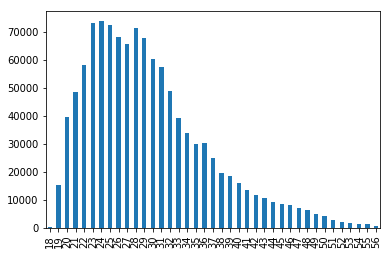

In [127]:
df['age'].value_counts().sort_index().plot(kind='bar',use_index=True)

In [128]:
age_kmeans = KMeans(n_clusters=8, random_state=2019).fit(df[['age']])

In [129]:
df['age_label'] = age_kmeans.labels_

In [130]:
df.head()

,listing_id,user_id,auditing_date,due_date,due_amt,hist_loans,hist_interest_mean,hist_interest_median,hist_interest_std,hist_interest_max,hist_interest_min,hist_interest_skew,hist_interest_sum,hist_principal_mean,hist_principal_median,hist_principal_std,hist_principal_max,hist_principal_min,hist_principal_skew,hist_principal_sum,hist_term_mean,hist_term_median,hist_term_std,hist_term_max,hist_term_min,hist_term_skew,hist_term_sum,principal_per_term_mean,principal_per_term_median,principal_per_term_std,principal_per_term_max,principal_per_term_min,principal_per_term_skew,principal_per_term_sum,term,rate,principal,principal_per_term,ttl_due_amt,ttl_interest,interest_per_term,ttl_interest/ttl_due_amt,principal_per_term/due_amt,ttl_interest/principal,due_period,due_amt_per_days,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,time_bt_aud&reg,time_bt_info&reg,cell&id_province_is_same,tag_insert_date,tag_vec0,tag_vec1,tag_vec2,tag_vec3,tag_vec4,tag_vec5,tag_vec6,tag_vec7,tag_vec8,tag_vec9,tag_vec10,tag_vec11,tag_vec12,tag_vec13,tag_vec14,tag_vec15,tag_vec16,tag_vec17,tag_vec18,tag_vec19,tag_vec20,tag_vec21,tag_vec22,tag_vec23,tag_vec24,tag_vec25,tag_vec26,tag_vec27,tag_vec28,tag_vec29,tag_vec30,tag_vec31,tag_vec32,tag_vec33,tag_vec34,tag_vec35,tag_vec36,tag_vec37,tag_vec38,tag_vec39,tag_vec40,tag_vec41,tag_vec42,tag_vec43,tag_vec44,tag_vec45,tag_vec46,tag_vec47,tag_vec48,tag_vec49,tag_vec50,tag_vec51,tag_vec52,tag_vec53,tag_vec54,tag_vec55,tag_vec56,tag_vec57,tag_vec58,tag_vec59,tag_vec60,tag_vec61,tag_vec62,tag_vec63,tag_vec64,tag_vec65,tag_vec66,tag_vec67,tag_vec68,tag_vec69,tag_vec70,tag_vec71,tag_vec72,tag_vec73,tag_vec74,tag_vec75,tag_vec76,tag_vec77,tag_vec78,tag_vec79,tag_vec80,tag_vec81,tag_vec82,tag_vec83,tag_vec84,tag_vec85,tag_vec86,tag_vec87,tag_vec88,tag_vec89,tag_vec90,tag_vec91,tag_vec92,tag_vec93,tag_vec94,tag_vec95,tag_vec96,tag_vec97,tag_vec98,tag_vec99,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数,1月内behavior的个数,1月内behavior为1的个数,1月内behavior为2的个数,1月内behavior为3的个数,latest_early_repay_days,latest_(due_amt/early_repay_date),repay_mean,(due_amt/early_repay_date)_mean,(due_amt/early_repay_date)_std,(due_amt/early_repay_date)_median,(due_amt/early_repay_date)_max,(due_amt/early_repay_date)_min,early_repay_days_max,early_repay_days_min,early_repay_days_median,early_repay_days_sum,early_repay_days_mean,early_repay_days_std,early_repay_days_skew,due_amt_max,due_amt_min,due_amt_median,due_amt_mean,due_amt_sum,due_amt_std,due_amt_skew,due_amt_kurt,due_amt_ptp,age_label
0,3163926,748147,2018-04-25,2018-05-25,72.1167,1.0,5450.250000,5450.250000,NaN,5450.250000,5450.250000,NaN,5450.250000,1170.000000,1170.0,NaN,1170.0,1170.0,NaN,1170.0,12.000000,12.0,NaN,12.0,12.0,NaN,12.0,97.500000,97.500000,NaN,97.500000,97.5,NaN,97.500000,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,2018-04-24,-0.000148,0.013667,0.005875,-0.019955,0.000240,-0.020825,0.004221,-0.021815,0.028067,-0.052579,0.011826,-0.028754,0.027409,0.045794,-0.033328,0.016786,0.001544,-0.058314,-0.024197,-0.059824,-0.032613,0.010424,0.037261,-0.021309,0.006157,-0.046465,-0.009872,-0.056729,-0.028117,0.019223,-0.005544,0.012617,0.008709,0.021552,0.031220,0.060249,0.101478,-0.011949,0.020513,-0.056565,0.034455,0.043009,-0.003433,0.008795,-0.016725,-0.029056,-0.000214,0.067132,0.002393,0.019757,-0.022705,0.032985,0.040734,-0.043754,0.006345,-0.002365,0.011103,0.007401,0.066504,-0.071858,0.014950,-0.013808,-0.003941,0.013870,0.021075,0.021733,-0.028196,-0.014172,0.030511,0.022916,-0.011125,-0.020695,0.056456,0.038802,0.015105,0.026400,-0.033989,-0.006064,-0.027631,-0.033680,-0.007108,-0.054933,0.033178,-0.025412,-0.057076,-0.066621,-0.022494,0.025116,-0.073519,0.051550,-0.010137,0.075107,-0.041206,-0.016192,-0.013864,-0.025920,-0.038457,-0.026860,-0.030525,-0.036897,52,11.0,2.0,39.0,18.0,5.0,1.0,12.0,28.0,3.520766,1.0,3.520766,NaN

In [131]:
age_groups = df.groupby('age_label',as_index=False)

In [132]:
# 各组的'early_repay_days_mean'统计信息
df = df.merge(age_groups['early_repay_days_mean'].agg({
    'early_repay_days_mean_age_mean':'mean', 'early_repay_days_mean_age_std':'std'
}), on='age_label', how='left')

In [133]:
# 各组的'early_repay_days_median'统计信息
df = df.merge(age_groups['early_repay_days_median'].agg({
    'early_repay_days_median_age_mean':'mean', 'early_repay_days_median_age_std':'std'
}), on='age_label', how='left')

In [134]:
# 各组的'hist_principal_mean'统计信息
df = df.merge(age_groups['hist_principal_mean'].agg({
    'hist_principal_mean_age_mean':'mean', 'hist_principal_mean_age_std':'std'
}), on='age_label', how='left')

In [135]:
# 各组的'due_amt_mean'统计信息
df = df.merge(age_groups['due_amt_mean'].agg({
    'due_amt_mean_age_mean':'mean', 'due_amt_mean_age_std':'std'
}), on='age_label', how='left')

In [136]:
# 各组的'hist_loans'统计信息
df = df.merge(age_groups['hist_loans'].agg({
    'hist_loans_age_mean':'mean', 'hist_loans_age_std':'std'
}), on='age_label', how='left')

In [137]:
# 计算个体值和组统计均值的差值
df['early_repay_days_mean_age_diff'] = df['early_repay_days_mean'] - df['early_repay_days_mean_age_mean']
df['early_repay_days_median_age_diff'] = df['early_repay_days_median'] - df['early_repay_days_median_age_mean']
df['hist_principal_mean_age_diff'] = df['hist_principal_mean'] - df['hist_principal_mean_age_mean']
df['due_amt_mean_age_diff'] = df['due_amt_mean'] -df['due_amt_mean_age_mean']
df['hist_loans_age_diff'] = df['hist_loans'] -df['hist_loans_age_mean']

In [138]:
del df['age_label']

# 根据hist_loans聚合

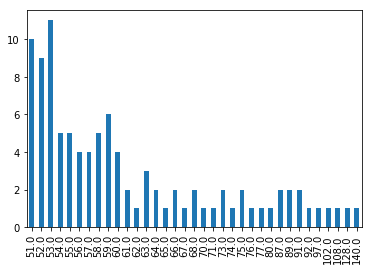

In [139]:
df[df['hist_loans']>50]['hist_loans'].value_counts().sort_index().plot(kind='bar',use_index=True)

In [140]:
hist_loans_kmeans = KMeans(n_clusters=8, random_state=2019).fit(df[['hist_loans']])

In [141]:
df['hist_loans_label'] = hist_loans_kmeans.labels_

In [142]:
hist_loans_groups = df.groupby('hist_loans_label',as_index=False)

In [143]:
# 各组的'early_repay_days_mean'统计信息
df = df.merge(hist_loans_groups['early_repay_days_mean'].agg({
    'early_repay_days_mean_hist_mean':'mean', 'early_repay_days_mean_hist_std':'std'
}), on='hist_loans_label', how='left')

In [144]:
# 各组的'early_repay_days_median'统计信息
df = df.merge(hist_loans_groups['early_repay_days_median'].agg({
    'early_repay_days_median_hist_mean':'mean', 'early_repay_days_median_hist_std':'std'
}), on='hist_loans_label', how='left')

In [145]:
# 计算个体值和组统计均值的差值
df['early_repay_days_mean_hist_diff'] = df['early_repay_days_mean'] - df['early_repay_days_mean_hist_mean']
df['early_repay_days_median_hist_diff'] = df['early_repay_days_median'] - df['early_repay_days_median_hist_mean']

In [146]:
del df['hist_loans_label']

# 处理类别特征和日期

In [147]:
cate_cols = ['gender', 'cell_province', 'id_province', 'id_city']

In [148]:
# 这个lgb应该有参数可以直接传 lgb.train(categorical_feature=cate_cols)
for f in cate_cols:
    df[f] = df[f].map(dict(zip(df[f].unique(), range(df[f].nunique())))).astype('int32')

In [149]:
date_cols = ['auditing_date', 'due_date', 'reg_mon', 'info_insert_date', 'tag_insert_date']

In [150]:
for f in date_cols:
    if f in ['reg_mon', 'info_insert_date', 'tag_insert_date']:
        df[f + '_year'] = df[f].dt.year
    df[f + '_month'] = df[f].dt.month
    if f in ['auditing_date', 'due_date', 'info_insert_date', 'tag_insert_date']:
        df[f + '_day'] = df[f].dt.day
        df[f + '_dayofweek'] = df[f].dt.dayofweek

In [151]:
df.drop(columns=date_cols, axis=1, inplace=True)

In [152]:
df['big_month'] = df['auditing_date_month'].apply(lambda x: 1 if x in [1,3,5,7,8,10,12] else 0)
df['February'] = df['auditing_date_month'].apply(lambda x: 1 if x==2 else 0)

In [153]:
# one-hot encoding for tags
df['taglist'] = df['taglist'].astype('str').apply(lambda x: x.strip().replace('|', ' ').strip())

KeyError: 'taglist'

In [ ]:
# vectorizer = CountVectorizer(min_df=10, max_df=0.9)
# tag_cv = vectorizer.fit_transform(df['taglist'])

In [ ]:
del df['user_id'], df['listing_id']

In [ ]:
# 也可以用lgb.train(categorical_features=cate_cols)
df = pd.get_dummies(df, columns=cate_cols)
df = pd.get_dummies(df, columns=cate_cols2)

# 训练模型

In [ ]:
def add_1_month(s):
    s = s.strftime('%F')
    y, m, d = str(s).split('-')
    y = int(y)
    m = int(m)
    d = int(d)
    m = m + 1
    if m == 13:
        m = 1
        y = y + 1
    if m in [4,6,9,11]:
        if d == 31:
            d = 30
    if m == 2:
        if d in [29, 30, 31]:
            if y in [2012, 2016]:
                d = 29
            else:
                d = 28
    return datetime.datetime.strptime(str(y)+'-'+str(m)+'-'+str(d), '%Y-%m-%d')

In [ ]:
# 把整个验证集看作一个资产组合计算rmse
def new_rmse(val_df, prob_oof):
    val_df2=val_df[['listing_id']].copy()
    # 制作一个类似submission的表
    val_df['pre_repay_date'] = val_df['auditing_date']
    val_df_temp = val_df.copy()
    for i in range(31):
        val_df_temp['pre_repay_date'] = plus_1_day(val_df_temp['pre_repay_date'])
        val_df= pd.concat([val_df, val_df_temp],axis=0, ignore_index=True)
    val_df = val_df[val_df['pre_repay_date']<=val_df['due_date']]
    
    prob_cols = ['prob_{}'.format(i) for i in range(33)]
    for i, f in enumerate(prob_cols):
        val_df2[f] = prob_oof[:, i]
    val_df = val_df.merge(val_df2, on='listing_id', how='left')
    val_df['days'] = (val_df['due_date'] - val_df['pre_repay_date']).dt.days
    val_prob = val_df[prob_cols].values
    val_labels = val_df['days'].values
    val_prob = [val_prob[i][val_labels[i]] for i in range(val_prob.shape[0])]
    
    val_df['pre_repay_amt'] = val_df['due_amt'] * val_prob
    val_df['repay_amt'] = val_df[val_df['pre_repay_date']==val_df['repay_date']]['due_amt']
    groups_date = val_df.groupby('pre_repay_date')
    repay_amt = groups_date.repay_amt.sum()
    pre_repay_amt = groups_date.pre_repay_amt.sum()
    days = groups_date.ngroups
    
    return np.sqrt(mean_squared_error(repay_amt, pre_repay_amt))

In [ ]:
feature_name = np.concatenate((df.keys(),vectorizer.get_feature_names()))

In [ ]:
df_sp = sparse.hstack((df.values, tag_cv), format='csr', dtype='float32')

In [ ]:
train_values, test_values = df_sp[:train_num], df_sp[train_num:]

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
clf = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_leaves=70,
    reg_alpha=3,
    reg_lambda=5,
    max_depth=7,
    n_jobs=87,
    learning_rate=0.1,
    n_estimators=5000,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.77,
    random_state=2019,
    min_child_weight=4,
    min_child_samples=5,
    min_split_gain=0
)
amt_oof = np.zeros(train_num)
prob_oof = np.zeros((train_num, 33))
test_pred_prob = np.zeros((test_values.shape[0], 33))
for i, (trn_idx, val_idx) in enumerate(skf.split(train_values, clf_labels)):
    print(i, 'fold...')
    t = time.time()

    trn_x, trn_y = train_values[trn_idx], clf_labels[trn_idx]
    val_x, val_y = train_values[val_idx], clf_labels[val_idx]
    val_repay_amt = amt_labels[val_idx]
    val_due_amt = train_due_amt_df[val_idx]
    val_df = train_df[['listing_id','auditing_date','due_date','due_amt','repay_date']].iloc[val_idx]

    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        early_stopping_rounds=50, verbose=5, feature_name=list(feature_name)
    )
    # shape = (-1, 33)
    val_pred_prob_everyday = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    prob_oof[val_idx] = val_pred_prob_everyday
    val_pred_prob_today = [val_pred_prob_everyday[i][val_y[i]] for i in range(val_pred_prob_everyday.shape[0])]
    val_pred_repay_amt = val_due_amt * val_pred_prob_today
    print('val rmse:', np.sqrt(mean_squared_error(val_repay_amt, val_pred_repay_amt)))
    print('val mae:', mean_absolute_error(val_repay_amt, val_pred_repay_amt))
    print('val new rmse:', new_rmse(val_df, val_pred_prob_everyday))
    amt_oof[val_idx] = val_pred_repay_amt
    test_pred_prob += clf.predict_proba(test_values, num_iteration=clf.best_iteration_) / skf.n_splits

    print('runtime: {}\n'.format(time.time() - t))

print('\ncv rmse:', np.sqrt(mean_squared_error(amt_labels, amt_oof)))
print('cv mae:', mean_absolute_error(amt_labels, amt_oof))
print('cv logloss:', log_loss(clf_labels, prob_oof))
print('cv acc:', accuracy_score(clf_labels, np.argmax(prob_oof, axis=1)))
print('cv new_rmse:', new_rmse(train_df[['listing_id','auditing_date','due_date','due_amt','repay_date']], prob_oof))

In [ ]:
# # 原本的输出
# prob_cols = ['prob_{}'.format(i) for i in range(33)]
# for i, f in enumerate(prob_cols):
#     sub[f] = test_pred_prob[:, i]
# sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])
# sub_example = sub_example.merge(sub, on='listing_id', how='left')
# sub_example['days'] = (sub_example['repay_date'] - sub_example['auditing_date']).dt.days
# # shape = (-1, 33)
# test_prob = sub_example[prob_cols].values
# test_labels = sub_example['days'].values
# test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]
# sub_example['repay_amt'] = sub_example['due_amt'] * test_prob
# sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv('sub.csv', index=False)

In [ ]:
import pickle
with open("test_pred_prob8.pkl", 'wb') as f:
    pickle.dump(test_pred_prob, f)

In [ ]:
prob_cols = ['prob_{}'.format(i) for i in range(33)]

In [ ]:
for i, f in enumerate(prob_cols):
    sub[f] = test_pred_prob[:, i]

In [ ]:
sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])

In [ ]:
sub_example = sub_example.merge(sub, on='listing_id', how='left')

In [ ]:
sub_example['due_date'] = sub_example['auditing_date'].parallel_apply(add_1_month)

In [ ]:
sub_example['days'] = (sub_example['due_date'] - sub_example['repay_date']).dt.days

In [ ]:
test_prob = sub_example[prob_cols].values

In [ ]:
test_labels = sub_example['days'].values

In [ ]:
test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]

In [ ]:
sub_example['repay_amt'] = sub_example['due_amt'] * test_prob

In [ ]:
sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv", index=False)

In [ ]:
lgb.plot_importance(clf, max_num_features=100,figsize=(10,30))

In [ ]:
sub_example2 = sub_example.copy()

In [ ]:
sub_example2['prob'] = test_prob

In [ ]:
threshold_up = 0.57
id_with_highpro = sub_example[sub_example2['prob']>=threshold_up]['listing_id']

In [ ]:
sub_example2.loc[sub_example2['listing_id'].isin(id_with_highpro.values),'repay_amt']=0

In [ ]:
sub_example2['repay_amt']= sub_example2.apply(lambda x:x['repay_amt'] if x['prob']<threshold_up else x['due_amt'],axis=1)

In [ ]:
sub_example2[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_0_{threshold_up}.csv", index=False)

In [ ]:
sub_example.groupby('auditing_date').apply(lambda x:x['repay_amt'].sum()).plot(kind='line')

In [ ]:
sub_example.groupby('repay_date').apply(lambda x:x['repay_amt'].sum()).plot(kind='line')

def alter(df, date, a):
    """
    data就是要增加的日期
    a就是这天增加的比例
    """
    if date not in df['repay_date'].values:
        return df
    else:
        dates = df['repay_date'].tolist()
        dates.remove(date)
        df = df.set_index('repay_date')
        b = df.loc[date, 'repay_amt'] * a
        df.loc[date, 'repay_amt'] += b
        df.loc[dates, 'repay_amt'] -= b / len(dates)
        df.reset_index(inplace=True)
        return df

sub_example_1 = sub_example.copy()

sub_example_1['repay_date']=sub_example_1['repay_date'].astype(str)

sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-29", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-30", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-31", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]

sub_example_1.to_csv("sub_ex.csv",index=False)